<a href="https://colab.research.google.com/github/piotrciechowicz/fake_news_detection/blob/main/Fake_news_detection_DS_FakeNewsNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score

!pip install pandas-profiling
from pandas_profiling import ProfileReport
from pathlib import Path
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 95.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=fa5b2312b249149ba6de7e812ab15a2cf573aede9e08de

<ipython-input-1-fcb097f69733>:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=aacc9d4dcebbb5f766f6c77686b995b1ca07a5adda95ab9e48ffce9327c5e6db
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#Functions

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(texts):
    output= [i for i in texts if i not in stopwords]
    return output

In [3]:
interpunction = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', ':', ';', '<', '=', '>', '?', '@', '[', '', ']', '^', '_', '`', '{', '|', '}', '~']
def remove_interpunction(texts):
    output= [i for i in texts if i not in interpunction]
    return output

In [4]:
lemmatizer = WordNetLemmatizer()
def lemmatize(texts):
    lem_text = [lemmatizer.lemmatize(word) for word in texts]
    return lem_text

In [5]:
def test_model(X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0


  with torch.no_grad():
    correct_test = 0
    total_test = 0
    outputs_test = torch.squeeze(model(X_test))
    loss_test = criterion(outputs_test, y_test)

    predicted_test = outputs_test.round().detach().numpy()
    total_test += y_test.size(0)
    correct_test += np.sum(predicted_test == y_test.detach().numpy())
    accuracy_test = 100 * correct_test/total_test
    losses_test.append(loss_test.item())

    print(f"Test - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")

In [6]:
def use_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0

  for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
      x = X_train
      labels = y_train
      optimizer.zero_grad() 
      outputs = model(X_train)
      loss = criterion(torch.squeeze(outputs), labels) 
      
      loss.backward() 
      
      optimizer.step() 
      
      iter+=1
      if iter%(epochs/5)==0:
          with torch.no_grad():
              correct_test = 0
              total_test = 0
              outputs_test = torch.squeeze(model(X_test))
              loss_test = criterion(outputs_test, y_test)
              
              predicted_test = outputs_test.round().detach().numpy()
              total_test += y_test.size(0)
              correct_test += np.sum(predicted_test == y_test.detach().numpy())
              accuracy_test = 100 * correct_test/total_test
              losses_test.append(loss_test.item())
              total = 0
              correct = 0
              total += y_train.size(0)
              correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
              accuracy = 100 * correct/total
              losses.append(loss.item())
              Iterations.append(iter)

              print(f"Iteration: {iter}. \nVal - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
              print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
  return accuracy

In [7]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [8]:
def validation_with_StratifiedKFold(X_train, y_train, X_val, y_val, X_test, y_test, 
                                    n_splits, model, criterion, optimizer, epochs):

  skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 8)

  for fold,(train_idx,test_idx) in enumerate(skf.split(X_train, y_train)):

    print('\n')   
    print('------------fold no---------{}----------------------'.format(fold))
    print('\n')   

    x_train_fold, x_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    model_lr.apply(reset_weights)
    
    print('\n')    
    print('Fit model on train part of dataset')
    print('\n')  
    use_model(x_train_fold, y_train_fold, x_test_fold, y_test_fold, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on validation part of dataset')
    print('\n')  
    test_model(X_val, y_val, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on test part of dataset')
    print('\n') 
    test_model(X_test, y_test, 
               model, criterion, 
               optimizer, epochs)

#Importing dataset

In [9]:
path_fakenewsnet = '/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/Fake news net/FakeNewsNet.csv'
df = pd.read_csv(path_fakenewsnet)

In [10]:
df.sample(3)

,title,news_url,source_domain,tweet_num,real
1118,Nikki Reed Responds to Backlash Over Ian Somer...,www.eonline.com/news/882190/nikki-reed-respond...,www.eonline.com,66,0
15013,‘A Star Is Born’ With Lady Gaga & Bradley Coop...,deadline.com/2018/04/a-star-is-born-with-lady-...,deadline.com,18,0
13455,Attention Swifties: Taylor Swift Is Back Hosti...,https://www.longroom.com/discussion/729566/att...,www.longroom.com,84,1


# Exploratory data analysis

In [11]:
df = df.rename({'real': 'is_real'}, axis='columns')

In [12]:
df_2 = df.drop(['news_url','source_domain','tweet_num'],axis=1)

In [13]:
print('Shape:')
print(df_2.shape)
print('-'*80, '\n')
print('Duplicates:')
print(df_2.duplicated().sum())
print('-'*80, '\n')
print('Missing values:')
print(df_2.isnull().sum())
print('-'*80, '\n')

Shape:
(23196, 2)
-------------------------------------------------------------------------------- 

Duplicates:
1349
-------------------------------------------------------------------------------- 

Missing values:
title      0
is_real    0
dtype: int64
-------------------------------------------------------------------------------- 



In [14]:
df_2 = df_2.drop_duplicates()

In [15]:
df_3 = df_2.dropna(axis='index')

In [16]:
print('Shape:')
print(df_3.shape)
print('-'*80, '\n')
print('Duplicates:')
print(df_3.duplicated().sum())
print('-'*80, '\n')
print('Missing values:')
print(df_3.isnull().sum())
print('-'*80, '\n')

Shape:
(21847, 2)
-------------------------------------------------------------------------------- 

Duplicates:
0
-------------------------------------------------------------------------------- 

Missing values:
title      0
is_real    0
dtype: int64
-------------------------------------------------------------------------------- 



1    16524
0     5323
Name: is_real, dtype: int64
-------------------------------------------------------------------------------- 



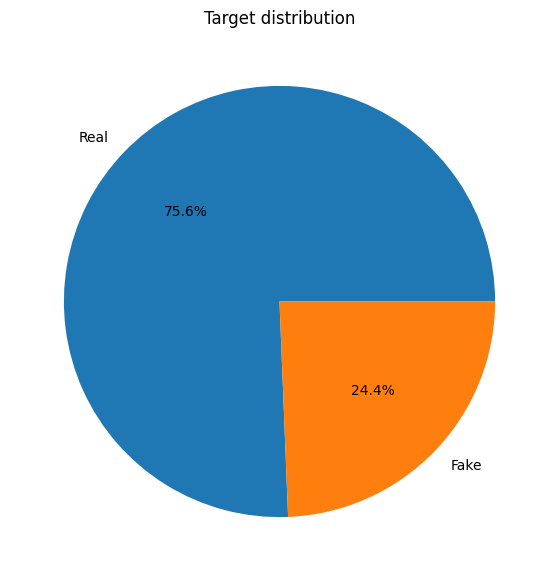

In [31]:
print(df_3['is_real'].value_counts())
print('-'*80, '\n')
fig, ax = plt.subplots(figsize = (7,7))
ax.pie(df_3['is_real'].value_counts(),labels=['Real','Fake'], autopct='%1.1f%%')
ax.set_title('Target distribution')
plt.show()

#Pandas profiling

In [18]:
prof = ProfileReport(df_2)
prof.to_file(Path("/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/pandas_profiling_report_fakenewsnet.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#Feature engeneering

##Upsampling

In [32]:
df_3_fake = df_3[df_3['is_real']==0]
df_3_true = df_3[df_3['is_real']==1]

In [33]:
df_3_fake_upsample = resample(df_3_fake,
             replace=True,
             n_samples=len(df_3_true),
             random_state=42)

In [34]:
data = pd.concat([df_3_fake_upsample,df_3_true], ignore_index = True)

In [35]:
print(data['is_real'].value_counts())
print('-'*80, '\n')

0    16524
1    16524
Name: is_real, dtype: int64
-------------------------------------------------------------------------------- 



In [36]:
X_0 = data['title']
y = data['is_real']

##Lowering the text

In [38]:
X_low = X_0.map(lambda x: x.lower())

##Tokenization

In [39]:
X_tokenize = X_low.map(lambda x: word_tokenize(x))

##Removing stopwords

In [40]:
X_stopwords = X_tokenize.map(lambda x: remove_stopwords(x))

##Removing interpuntion

In [41]:
X_interpunction = X_stopwords.map(lambda x: remove_interpunction(x))

##Converting words to lemma

In [42]:
X_lemmatize = X_interpunction.map(lambda x: lemmatize(x))

#WordCloud

In [43]:
X = X_lemmatize.astype(str)

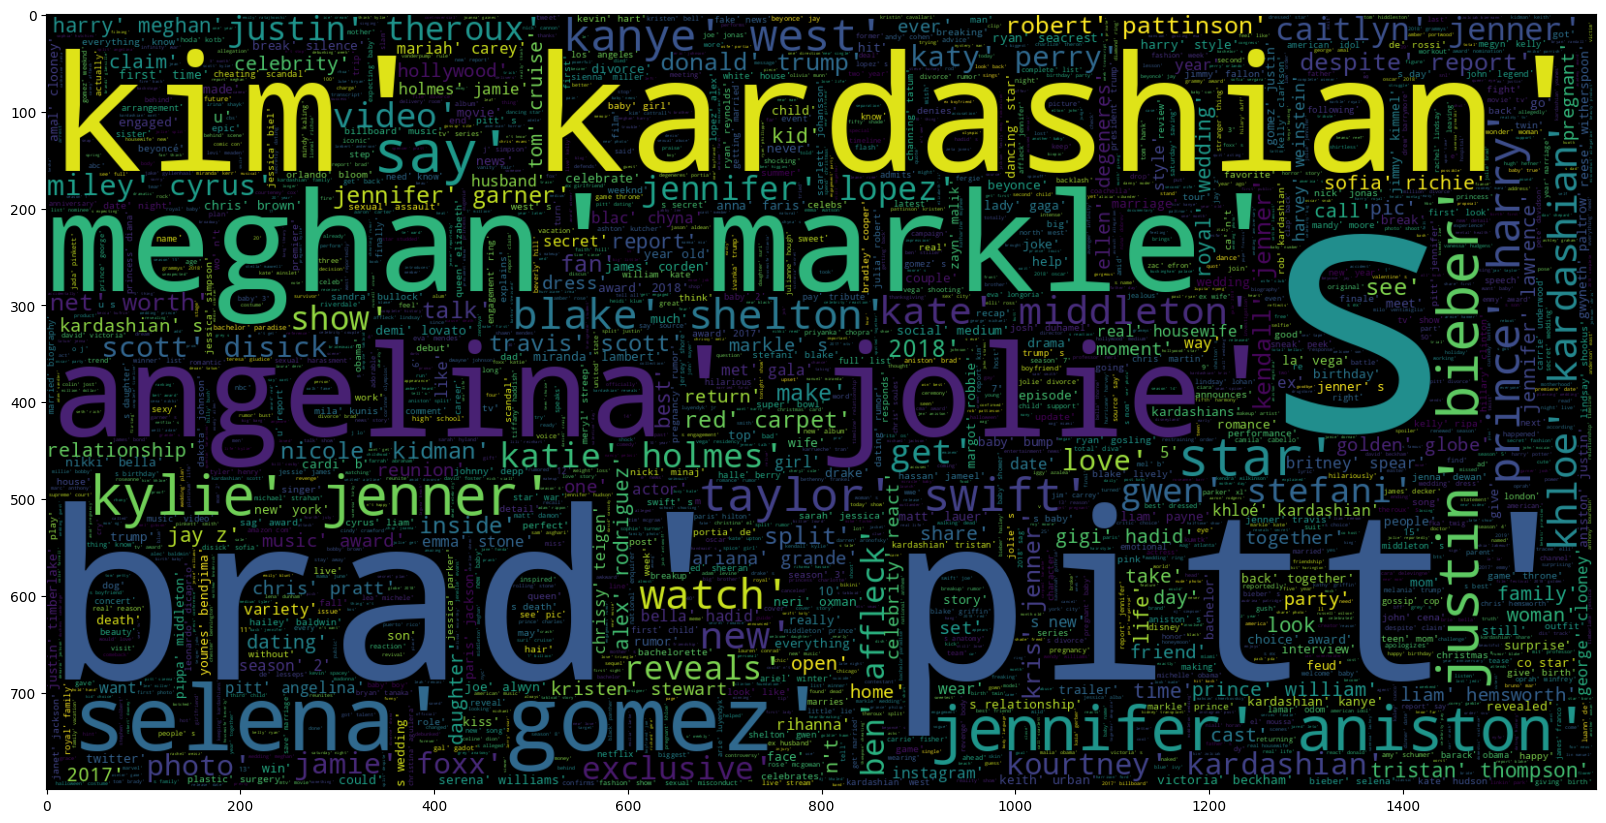

In [44]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(X))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

#Modeling

##Split dataset

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8, random_state = 8, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 8, stratify=y_test)

##TfidfVectorizer

In [46]:
tfidf = TfidfVectorizer(max_features=100)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

#Logistic Regression with PyTorch

###Model logistic regression

In [47]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [48]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
learning_rate = 0.01

In [49]:
model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

In [50]:
X_train_py, X_val_py, X_test_py = torch.Tensor(X_train_tfidf.toarray()),torch.Tensor(X_val_tfidf.toarray()),torch.Tensor(X_test_tfidf.toarray())
y_train_py, y_val_py, y_test_py = torch.Tensor(y_train.to_numpy()),torch.Tensor(y_val.to_numpy()),torch.Tensor(y_test.to_numpy())

In [51]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

Training Epochs:  22%|██▏       | 2224/10000 [00:02<00:06, 1122.36it/s]

Iteration: 2000. 
Val - Loss: 0.676982581615448. Accuracy: 67.11043872919818
Train -  Loss: 0.6773139834403992. Accuracy: 66.10682402784083



Training Epochs:  42%|████▏     | 4169/10000 [00:03<00:04, 1190.74it/s]

Iteration: 4000. 
Val - Loss: 0.6648575663566589. Accuracy: 69.38729198184569
Train -  Loss: 0.6652207374572754. Accuracy: 68.57315781510061



Training Epochs:  62%|██████▏   | 6164/10000 [00:05<00:04, 820.72it/s]

Iteration: 6000. 
Val - Loss: 0.6544572710990906. Accuracy: 69.79576399394857
Train -  Loss: 0.6548424959182739. Accuracy: 69.2086548645786



Training Epochs:  82%|████████▏ | 8156/10000 [00:08<00:02, 773.68it/s]

Iteration: 8000. 
Val - Loss: 0.6454935669898987. Accuracy: 69.99243570347957
Train -  Loss: 0.6458922624588013. Accuracy: 69.5869269178393



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 935.58it/s]

Iteration: 10000. 
Val - Loss: 0.6377292275428772. Accuracy: 70.05295007564297
Train -  Loss: 0.6381340026855469. Accuracy: 69.72310485701317



69.72310485701317

###Optuna

In [52]:
def objective(trial):

  input_dim = X_train_tfidf.shape[1]
  output_dim = 1

  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}

  model_lr = LogisticRegression(input_dim,output_dim)
  criterion_lr = torch.nn.BCELoss()
  optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

  accuracy = use_model(X_train_py, y_train_py, X_val_py, y_val_py, 
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

  return accuracy

In [53]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=600)

[I 2023-04-17 17:15:32,483] A new study created in memory with name: no-name-bd086ae0-25fe-441e-a430-cd6977a64ff9
<ipython-input-52-eca541b33e7e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}
Training Epochs:  22%|██▏       | 2214/10000 [00:02<00:06, 1167.15it/s]

Iteration: 2000. 
Val - Loss: 0.6806291937828064. Accuracy: 65.26475037821483
Train -  Loss: 0.6802188754081726. Accuracy: 65.21410198214556



Training Epochs:  42%|████▏     | 4171/10000 [00:03<00:04, 1176.17it/s]

Iteration: 4000. 
Val - Loss: 0.667992115020752. Accuracy: 68.62329803328291
Train -  Loss: 0.6676409244537354. Accuracy: 68.5580269329702



Training Epochs:  61%|██████▏   | 6143/10000 [00:05<00:03, 1185.86it/s]

Iteration: 6000. 
Val - Loss: 0.6571751236915588. Accuracy: 69.62934947049925
Train -  Loss: 0.6568735837936401. Accuracy: 69.29944015736118



Training Epochs:  82%|████████▏ | 8228/10000 [00:07<00:01, 1233.56it/s]

Iteration: 8000. 
Val - Loss: 0.6478719711303711. Accuracy: 69.90922844175492
Train -  Loss: 0.6476109027862549. Accuracy: 69.43561809653502



Training Epochs: 100%|██████████| 10000/10000 [00:08<00:00, 1167.21it/s]
[I 2023-04-17 17:15:41,060] Trial 0 finished with value: 69.55666515357845 and parameters: {'lr': 0.024771561885569962}. Best is trial 0 with value: 69.55666515357845.


Iteration: 10000. 
Val - Loss: 0.639829695224762. Accuracy: 70.10590015128594
Train -  Loss: 0.6396012306213379. Accuracy: 69.55666515357845



Training Epochs:  22%|██▏       | 2241/10000 [00:01<00:06, 1218.10it/s]

Iteration: 2000. 
Val - Loss: 0.6804918646812439. Accuracy: 65.86989409984871
Train -  Loss: 0.6801912784576416. Accuracy: 65.54698138901497



Training Epochs:  42%|████▏     | 4159/10000 [00:04<00:07, 828.33it/s]

Iteration: 4000. 
Val - Loss: 0.6679078340530396. Accuracy: 68.38880484114978
Train -  Loss: 0.6676750779151917. Accuracy: 67.9679225298835



Training Epochs:  61%|██████▏   | 6126/10000 [00:06<00:05, 765.09it/s]

Iteration: 6000. 
Val - Loss: 0.657135009765625. Accuracy: 69.24357034795764
Train -  Loss: 0.6569575667381287. Accuracy: 68.87577545770918



Training Epochs:  82%|████████▏ | 8212/10000 [00:09<00:01, 1059.79it/s]

Iteration: 8000. 
Val - Loss: 0.6478688716888428. Accuracy: 69.94704992435703
Train -  Loss: 0.6477354168891907. Accuracy: 69.3145710394916



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 932.99it/s]
[I 2023-04-17 17:15:51,789] Trial 1 finished with value: 69.28430927523074 and parameters: {'lr': 0.0992575606328055}. Best is trial 0 with value: 69.55666515357845.


Iteration: 10000. 
Val - Loss: 0.6398579478263855. Accuracy: 70.15885022692889
Train -  Loss: 0.6397585868835449. Accuracy: 69.28430927523074



Training Epochs:  22%|██▏       | 2190/10000 [00:01<00:06, 1248.88it/s]

Iteration: 2000. 
Val - Loss: 0.6766192317008972. Accuracy: 66.83055975794251
Train -  Loss: 0.6767504811286926. Accuracy: 66.51535784536239



Training Epochs:  41%|████▏     | 4128/10000 [00:03<00:04, 1253.65it/s]

Iteration: 4000. 
Val - Loss: 0.6645336151123047. Accuracy: 68.80484114977307
Train -  Loss: 0.6646865010261536. Accuracy: 68.37645634740505



Training Epochs:  62%|██████▏   | 6169/10000 [00:04<00:03, 1233.66it/s]

Iteration: 6000. 
Val - Loss: 0.6541761159896851. Accuracy: 69.31921331316188
Train -  Loss: 0.6543442606925964. Accuracy: 68.78499016492661



Training Epochs:  82%|████████▏ | 8193/10000 [00:06<00:01, 1212.96it/s]

Iteration: 8000. 
Val - Loss: 0.6452565789222717. Accuracy: 69.69742813918306
Train -  Loss: 0.645433783531189. Accuracy: 69.23891662883946



Training Epochs: 100%|██████████| 10000/10000 [00:08<00:00, 1235.89it/s]
[I 2023-04-17 17:15:59,890] Trial 2 finished with value: 69.35996368588289 and parameters: {'lr': 0.03173576759579817}. Best is trial 0 with value: 69.55666515357845.


Iteration: 10000. 
Val - Loss: 0.6375361084938049. Accuracy: 69.94704992435703
Train -  Loss: 0.6377168893814087. Accuracy: 69.35996368588289



Training Epochs:  21%|██        | 2121/10000 [00:04<00:10, 744.77it/s]

Iteration: 2000. 
Val - Loss: 0.678733766078949. Accuracy: 65.52950075642966
Train -  Loss: 0.677908718585968. Accuracy: 65.65289756392798



Training Epochs:  42%|████▏     | 4167/10000 [00:07<00:06, 833.87it/s]

Iteration: 4000. 
Val - Loss: 0.6664952039718628. Accuracy: 68.57791225416037
Train -  Loss: 0.6657614707946777. Accuracy: 68.69420487214404



Training Epochs:  62%|██████▏   | 6218/10000 [00:09<00:03, 1180.37it/s]

Iteration: 6000. 
Val - Loss: 0.6559999585151672. Accuracy: 69.43267776096823
Train -  Loss: 0.6553434729576111. Accuracy: 69.16326221818733



Training Epochs:  82%|████████▏ | 8172/10000 [00:10<00:01, 1169.19it/s]

Iteration: 8000. 
Val - Loss: 0.6469559669494629. Accuracy: 69.62934947049925
Train -  Loss: 0.646364152431488. Accuracy: 69.46587986079588



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 810.49it/s]
[I 2023-04-17 17:16:12,237] Trial 3 finished with value: 69.91980632470873 and parameters: {'lr': 0.032750125752639886}. Best is trial 3 with value: 69.91980632470873.


Iteration: 10000. 
Val - Loss: 0.6391223073005676. Accuracy: 70.17397881996975
Train -  Loss: 0.6385841965675354. Accuracy: 69.91980632470873



Training Epochs:  22%|██▏       | 2179/10000 [00:01<00:06, 1203.22it/s]

Iteration: 2000. 
Val - Loss: 0.6774232983589172. Accuracy: 66.66414523449319
Train -  Loss: 0.6778444051742554. Accuracy: 66.03116961718868



Training Epochs:  42%|████▏     | 4201/10000 [00:03<00:04, 1234.76it/s]

Iteration: 4000. 
Val - Loss: 0.6652854681015015. Accuracy: 68.58547655068078
Train -  Loss: 0.6657269597053528. Accuracy: 68.3461945831442



Training Epochs:  61%|██████▏   | 6139/10000 [00:05<00:04, 866.05it/s]

Iteration: 6000. 
Val - Loss: 0.6548753976821899. Accuracy: 69.40242057488653
Train -  Loss: 0.6553297638893127. Accuracy: 68.98169163262219



Training Epochs:  81%|████████  | 8109/10000 [00:07<00:02, 768.47it/s]

Iteration: 8000. 
Val - Loss: 0.6459040641784668. Accuracy: 69.75037821482601
Train -  Loss: 0.646364152431488. Accuracy: 69.11786957179604



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 961.10it/s]
[I 2023-04-17 17:16:22,657] Trial 4 finished with value: 69.23891662883946 and parameters: {'lr': 0.02763099594058572}. Best is trial 3 with value: 69.91980632470873.


Iteration: 10000. 
Val - Loss: 0.63813316822052. Accuracy: 69.75794251134644
Train -  Loss: 0.6385929584503174. Accuracy: 69.23891662883946



In [54]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 69.91980632470873
  Params: 
    lr: 0.032750125752639886


###StratifiedKFold

In [55]:
lr_best = trial.params['lr']
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [56]:
validation_with_StratifiedKFold(X_train_py, y_train_py,
                                X_val_py, y_val_py, 
                                X_test_py, y_test_py, 
                                n_splits = 5, model = model_lr, 
                                criterion = criterion_lr, optimizer = optimizer_lr, epochs = 10000)



------------fold no---------0----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  22%|██▏       | 2207/10000 [00:02<00:06, 1252.64it/s]

Iteration: 2000. 
Val - Loss: 0.654536783695221. Accuracy: 68.07866868381241
Train -  Loss: 0.6537682414054871. Accuracy: 69.68034802345376



Training Epochs:  42%|████▏     | 4173/10000 [00:03<00:04, 1291.22it/s]

Iteration: 4000. 
Val - Loss: 0.6298542618751526. Accuracy: 68.98638426626324
Train -  Loss: 0.6291336417198181. Accuracy: 69.39663325137128



Training Epochs:  62%|██████▏   | 6165/10000 [00:05<00:02, 1356.30it/s]

Iteration: 6000. 
Val - Loss: 0.6140483617782593. Accuracy: 69.36459909228442
Train -  Loss: 0.6131065487861633. Accuracy: 69.6425193871761



Training Epochs:  83%|████████▎ | 8277/10000 [00:06<00:01, 1391.58it/s]

Iteration: 8000. 
Val - Loss: 0.6034449934959412. Accuracy: 69.9697428139183
Train -  Loss: 0.6021575331687927. Accuracy: 69.68034802345376



Training Epochs: 100%|██████████| 10000/10000 [00:08<00:00, 1225.98it/s]


Iteration: 10000. 
Val - Loss: 0.5960515737533569. Accuracy: 69.66717095310136
Train -  Loss: 0.5943666696548462. Accuracy: 69.68034802345376



Evaluation model on validation part of dataset


Test - Loss: 0.5950309634208679. Accuracy: 70.16641452344932


Evaluation model on test part of dataset


Test - Loss: 0.5958197116851807. Accuracy: 70.44405779559725


------------fold no---------1----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  22%|██▏       | 2162/10000 [00:01<00:05, 1343.40it/s]

Iteration: 2000. 
Val - Loss: 0.6559878587722778. Accuracy: 67.0196671709531
Train -  Loss: 0.6519579887390137. Accuracy: 68.96160393417817



Training Epochs:  42%|████▏     | 4154/10000 [00:03<00:04, 1313.86it/s]

Iteration: 4000. 
Val - Loss: 0.6335145831108093. Accuracy: 68.22995461422087
Train -  Loss: 0.6270198822021484. Accuracy: 69.92623415925856



Training Epochs:  62%|██████▏   | 6165/10000 [00:05<00:04, 914.87it/s]

Iteration: 6000. 
Val - Loss: 0.619175136089325. Accuracy: 68.45688350983359
Train -  Loss: 0.6108589768409729. Accuracy: 70.11537734064687



Training Epochs:  82%|████████▏ | 8150/10000 [00:07<00:02, 843.54it/s]

Iteration: 8000. 
Val - Loss: 0.6095730066299438. Accuracy: 68.68381240544629
Train -  Loss: 0.5998402833938599. Accuracy: 70.0775487043692



Training Epochs: 100%|██████████| 10000/10000 [00:09<00:00, 1018.23it/s]


Iteration: 10000. 
Val - Loss: 0.6028815507888794. Accuracy: 68.75945537065053
Train -  Loss: 0.5920052528381348. Accuracy: 70.05863438623038



Evaluation model on validation part of dataset


Test - Loss: 0.5935947895050049. Accuracy: 70.3177004538578


Evaluation model on test part of dataset


Test - Loss: 0.5946251153945923. Accuracy: 70.30032528935622


------------fold no---------2----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  22%|██▏       | 2205/10000 [00:01<00:06, 1271.66it/s]

Iteration: 2000. 
Val - Loss: 0.6567754745483398. Accuracy: 67.77609682299546
Train -  Loss: 0.6534034609794617. Accuracy: 69.41554756951012



Training Epochs:  42%|████▏     | 4162/10000 [00:03<00:04, 1254.62it/s]

Iteration: 4000. 
Val - Loss: 0.63413405418396. Accuracy: 68.07866868381241
Train -  Loss: 0.6275746822357178. Accuracy: 69.9451484773974



Training Epochs:  62%|██████▏   | 6181/10000 [00:04<00:02, 1332.93it/s]

Iteration: 6000. 
Val - Loss: 0.620013415813446. Accuracy: 68.00302571860817
Train -  Loss: 0.6107912659645081. Accuracy: 70.32343484017402



Training Epochs:  82%|████████▏ | 8169/10000 [00:06<00:01, 1279.14it/s]

Iteration: 8000. 
Val - Loss: 0.610823392868042. Accuracy: 68.15431164901665
Train -  Loss: 0.5993331670761108. Accuracy: 70.41800643086816



Training Epochs: 100%|██████████| 10000/10000 [00:07<00:00, 1266.72it/s]


Iteration: 10000. 
Val - Loss: 0.604631781578064. Accuracy: 68.15431164901665
Train -  Loss: 0.5911816358566284. Accuracy: 70.51257802156232



Evaluation model on validation part of dataset


Test - Loss: 0.5935218334197998. Accuracy: 70.79425113464448


Evaluation model on test part of dataset


Test - Loss: 0.5942979454994202. Accuracy: 70.36840910810197


------------fold no---------3----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  22%|██▏       | 2185/10000 [00:01<00:06, 1179.86it/s]

Iteration: 2000. 
Val - Loss: 0.6567296981811523. Accuracy: 67.77609682299546
Train -  Loss: 0.6540828943252563. Accuracy: 69.01834688859466



Training Epochs:  41%|████      | 4112/10000 [00:03<00:06, 860.55it/s]

Iteration: 4000. 
Val - Loss: 0.6327487230300903. Accuracy: 69.9697428139183
Train -  Loss: 0.6290951371192932. Accuracy: 69.35880461509363



Training Epochs:  61%|██████    | 6115/10000 [00:05<00:04, 865.05it/s]

Iteration: 6000. 
Val - Loss: 0.6171553730964661. Accuracy: 69.7428139183056
Train -  Loss: 0.6129593253135681. Accuracy: 69.37771893323246



Training Epochs:  81%|████████▏ | 8132/10000 [00:08<00:02, 805.10it/s]

Iteration: 8000. 
Val - Loss: 0.6065043807029724. Accuracy: 69.7428139183056
Train -  Loss: 0.6019858717918396. Accuracy: 69.68034802345376



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 981.28it/s]


Iteration: 10000. 
Val - Loss: 0.5989322662353516. Accuracy: 70.27231467473526
Train -  Loss: 0.5941967964172363. Accuracy: 69.90731984111973



Evaluation model on validation part of dataset


Test - Loss: 0.5954987406730652. Accuracy: 70.4160363086233


Evaluation model on test part of dataset


Test - Loss: 0.5960527062416077. Accuracy: 70.38353884560102


------------fold no---------4----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  23%|██▎       | 2255/10000 [00:01<00:06, 1246.22it/s]

Iteration: 2000. 
Val - Loss: 0.6566294431686401. Accuracy: 68.88720666161998
Train -  Loss: 0.6559844017028809. Accuracy: 69.232223903177



Training Epochs:  42%|████▏     | 4154/10000 [00:03<00:04, 1314.16it/s]

Iteration: 4000. 
Val - Loss: 0.6315494179725647. Accuracy: 69.2657077971234
Train -  Loss: 0.6301096081733704. Accuracy: 69.8373676248109



Training Epochs:  62%|██████▏   | 6194/10000 [00:04<00:02, 1347.94it/s]

Iteration: 6000. 
Val - Loss: 0.6155547499656677. Accuracy: 69.11430734292203
Train -  Loss: 0.6133391857147217. Accuracy: 69.93192133131619



Training Epochs:  83%|████████▎ | 8262/10000 [00:06<00:01, 1342.87it/s]

Iteration: 8000. 
Val - Loss: 0.6048948764801025. Accuracy: 68.88720666161998
Train -  Loss: 0.6019091606140137. Accuracy: 69.98865355521936



Training Epochs: 100%|██████████| 10000/10000 [00:07<00:00, 1318.65it/s]

Iteration: 10000. 
Val - Loss: 0.5975344181060791. Accuracy: 69.11430734292203
Train -  Loss: 0.5937832593917847. Accuracy: 70.12102874432678



Evaluation model on validation part of dataset


Test - Loss: 0.5949190258979797. Accuracy: 70.24962178517399


Evaluation model on test part of dataset


Test - Loss: 0.5957458019256592. Accuracy: 70.2927604206067


###Without cutting "stopwords'

In [57]:
X_interpunction_2 = X_tokenize.map(lambda x: remove_interpunction(x))
X_lemmatize_2 = X_interpunction_2.map(lambda x: lemmatize(x))
X_2 = X_lemmatize_2.astype(str)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_2 = tfidf.fit_transform(X_train_2)
X_val_tfidf_2 = tfidf.transform(X_val_2)

In [58]:
input_dim = X_train_tfidf_2.shape[1]
output_dim = 1
lr = lr_best

model_lr_2 = LogisticRegression(input_dim,output_dim)
criterion_lr_2 = torch.nn.BCELoss()
optimizer_lr_2 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [59]:
X_train_py_2, X_val_py_2 = torch.Tensor(X_train_tfidf_2.toarray()),torch.Tensor(X_val_tfidf_2.toarray())
y_train_py_2, y_val_py_2 = torch.Tensor(y_train_2.to_numpy()),torch.Tensor(y_val_2.to_numpy())

In [60]:
use_model(X_train_py_2, y_train_py_2, X_val_py_2, y_val_py_2,
          model = model_lr_2, criterion = criterion_lr_2, 
          optimizer = optimizer_lr_2, epochs = 10000)

Training Epochs:  21%|██        | 2123/10000 [00:02<00:10, 782.28it/s]

Iteration: 2000. 
Val - Loss: 0.6939921975135803. Accuracy: 49.08279435682136
Train -  Loss: 0.6943112015724182. Accuracy: 48.79709487063096



Training Epochs:  41%|████      | 4109/10000 [00:05<00:07, 756.65it/s]

Iteration: 4000. 
Val - Loss: 0.6939921975135803. Accuracy: 49.08279435682136
Train -  Loss: 0.6943112015724182. Accuracy: 48.79709487063096



Training Epochs:  62%|██████▏   | 6204/10000 [00:07<00:03, 1137.51it/s]

Iteration: 6000. 
Val - Loss: 0.6939921975135803. Accuracy: 49.08279435682136
Train -  Loss: 0.6943112015724182. Accuracy: 48.79709487063096



Training Epochs:  82%|████████▏ | 8232/10000 [00:09<00:01, 1168.15it/s]

Iteration: 8000. 
Val - Loss: 0.6939921975135803. Accuracy: 49.08279435682136
Train -  Loss: 0.6943112015724182. Accuracy: 48.79709487063096



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 939.76it/s]

Iteration: 10000. 
Val - Loss: 0.6939921975135803. Accuracy: 49.08279435682136
Train -  Loss: 0.6943112015724182. Accuracy: 48.79709487063096



48.79709487063096

###Without lemmatization

In [61]:
X_3 = X_interpunction.astype(str)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_3 = tfidf.fit_transform(X_train_3)
X_val_tfidf_3 = tfidf.transform(X_val_3)

In [62]:
input_dim = X_train_tfidf_3.shape[1]
output_dim = 1
lr = lr_best

model_lr_3 = LogisticRegression(input_dim,output_dim)
criterion_lr_3 = torch.nn.BCELoss()
optimizer_lr_3 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [63]:
X_train_py_3, X_val_py_3 = torch.Tensor(X_train_tfidf_3.toarray()),torch.Tensor(X_val_tfidf_3.toarray())
y_train_py_3, y_val_py_3 = torch.Tensor(y_train_3.to_numpy()),torch.Tensor(y_val_3.to_numpy())

In [64]:
use_model(X_train_py_3, y_train_py_3, X_val_py_3, y_val_py_3,
          model = model_lr_3, criterion = criterion_lr_3, 
          optimizer = optimizer_lr_3, epochs = 10000)

Training Epochs:  22%|██▏       | 2210/10000 [00:01<00:06, 1158.96it/s]

Iteration: 2000. 
Val - Loss: 0.6925544738769531. Accuracy: 48.63648398199629
Train -  Loss: 0.6927443146705627. Accuracy: 48.6609169314571



Training Epochs:  41%|████▏     | 4145/10000 [00:03<00:04, 1222.25it/s]

Iteration: 4000. 
Val - Loss: 0.6925544738769531. Accuracy: 48.63648398199629
Train -  Loss: 0.6927443146705627. Accuracy: 48.6609169314571



Training Epochs:  61%|██████    | 6095/10000 [00:05<00:04, 911.12it/s]

Iteration: 6000. 
Val - Loss: 0.6925544738769531. Accuracy: 48.63648398199629
Train -  Loss: 0.6927443146705627. Accuracy: 48.6609169314571



Training Epochs:  82%|████████▏ | 8154/10000 [00:07<00:02, 803.22it/s]

Iteration: 8000. 
Val - Loss: 0.6925544738769531. Accuracy: 48.63648398199629
Train -  Loss: 0.6927443146705627. Accuracy: 48.6609169314571



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 978.53it/s]

Iteration: 10000. 
Val - Loss: 0.6925544738769531. Accuracy: 48.63648398199629
Train -  Loss: 0.6927443146705627. Accuracy: 48.6609169314571



48.6609169314571

#Deeper neutral network

In [65]:
class DeeperNN(nn.Module):

  def __init__(self, input_dim, output_dim):
      super().__init__()
      self.layer1 = nn.Linear(input_dim, 60)
      self.act1 = nn.ReLU()
      self.layer2 = nn.Linear(60, 60)
      self.act2 = nn.ReLU()
      self.layer3 = nn.Linear(60, 60)
      self.act3 = nn.ReLU()
      self.output = nn.Linear(60, output_dim)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.act1(self.layer1(x))
      x = self.act2(self.layer2(x))
      x = self.act3(self.layer3(x))
      x = self.sigmoid(self.output(x))
      return x

In [66]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_nn = DeeperNN(input_dim,output_dim)
criterion_nn = torch.nn.BCELoss()
optimizer_nn = torch.optim.SGD(model_nn.parameters(), lr=lr)

In [67]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_nn, criterion = criterion_nn, 
          optimizer = optimizer_nn, epochs = 10000)

Training Epochs:  20%|██        | 2009/10000 [00:27<01:36, 82.76it/s]

Iteration: 2000. 
Val - Loss: 0.6917469501495361. Accuracy: 61.91376701966717
Train -  Loss: 0.6917747855186462. Accuracy: 61.91556967771221



Training Epochs:  40%|████      | 4009/10000 [00:55<01:12, 82.56it/s]

Iteration: 4000. 
Val - Loss: 0.6563363671302795. Accuracy: 67.48865355521936
Train -  Loss: 0.6566752791404724. Accuracy: 67.55938871236194



Training Epochs:  60%|██████    | 6010/10000 [01:29<01:17, 51.39it/s]

Iteration: 6000. 
Val - Loss: 0.5666347742080688. Accuracy: 70.43116490166415
Train -  Loss: 0.5630902647972107. Accuracy: 70.58556513844758



Training Epochs:  80%|████████  | 8011/10000 [01:56<00:24, 81.07it/s]

Iteration: 8000. 
Val - Loss: 0.5637689232826233. Accuracy: 70.61270801815431
Train -  Loss: 0.5573979020118713. Accuracy: 70.90331366318657



Training Epochs: 100%|██████████| 10000/10000 [02:25<00:00, 68.85it/s]

Iteration: 10000. 
Val - Loss: 0.5614737868309021. Accuracy: 70.74886535552194
Train -  Loss: 0.5505149364471436. Accuracy: 71.23619307005599



71.23619307005599

#Similar news

In [68]:
X_emb = X[0:100]

In [69]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(X_emb)

In [70]:
cos_sim = util.cos_sim(embeddings, embeddings)

all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(X_emb[i], X_emb[j], cos_sim[i][j]))

Top-5 most similar pairs:
['kylie', 'jenner', 'major', 'regret', 'pregnancy', 'travis', 'scott', '—', 'tyga', '’', 'baby'] 	 ['kylie', 'jenner', '``', 'cool', "''", 'travis', 'scott', 'taking', '``', 'parenting', 'break', "''", 'hollywood', 'buzz'] 	 0.9401
['kim', 'kardashian', '‘', 'furious', '’', 'travis', 'scott', 'neglecting', 'pregnant', 'kylie', 'jenner'] 	 ['kylie', 'jenner', 'major', 'regret', 'pregnancy', 'travis', 'scott', '—', 'tyga', '’', 'baby'] 	 0.9212
['report', 'ryan', 'gosling', 'eva', 'mendes', 'split'] 	 ['ryan', 'gosling', 'pregnant', 'love', 'eva', 'mendes', "'have", 'broken'] 	 0.9155
['kim', 'kardashian', '‘', 'furious', '’', 'travis', 'scott', 'neglecting', 'pregnant', 'kylie', 'jenner'] 	 ['kylie', 'jenner', '``', 'cool', "''", 'travis', 'scott', 'taking', '``', 'parenting', 'break', "''", 'hollywood', 'buzz'] 	 0.8978
['justin', 'bieber', 'accidentally', 'hit', 'photographer', 'pick-up', 'truck', 'church', 'service'] 	 ['justin', 'bieber', 'pedophile', 'run'